# Getting Data from the Web
The internet is full of useful (as well as useless) information, so sometimes it might be very helpful to get data from it and process it locally.

There are different ways to get data from the web, the most used are:
- **Web Scraping**: download the html content from the page and then look from it to extract information
- **Using Web API**: APIs ([Application Programming Interface](https://en.wikipedia.org/wiki/API)) is code that is meant to be called from other code instead of displayed visually to a user. We'll be looking at the most common type: [REST API](https://en.wikipedia.org/wiki/Representational_state_transfer)

Often Web API need authentication, but ofter you can get a API key after a quick free signup.
[Here's a non-exaustive list](https://github.com/public-apis/public-apis) of open APIs.

## External Libraries
We'll be using these two external libraries:
- [requests](https://requests.readthedocs.io/en/master/): a more user-friendly alternative to the built-in library `urllib.request`
- [beautifulsoup4](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) a html parser, which is a type of software that builds a data structure from given inputs (usually of text kind).

which you can install by runnin the cell below

In [ ]:
!pip install requests beautifulsoup4

In [1]:
# let's import from them to check they were installed correctly
import requests
from bs4 import BeautifulSoup

## Web Scraping

In [2]:
r = requests.get("https://www.metaweather.com/21125/")
r

<Response [200]>

In [3]:
html_doc = r.text
html_doc[:200]

'\n<!DOCTYPE html>\n<html lang="en" dir="ltr">\n\t<head>\n\t\t<meta charset="utf-8">\n\t\t<meta http-equiv="X-UA-Compatible" content="IE=edge">\n\t\t<title>Glasgow - MetaWeather</title>\n\t\t<meta name="viewport" cont'

if you want you can try render the html within the notebook by using
```python
from IPython.core.display import HTML
HTML(r.text)
```

We could try an do string manipulation (or using [regular expression syntax](https://www.w3schools.com/python/python_regex.asp)), but using a pre-built parser is usually less painful :)

In [4]:
soup = BeautifulSoup(html_doc, 'html.parser')

In [7]:
weather_data = []

for item in soup.findAll('div'):
    if item.has_attr('data-date'):
        weather_date = item['data-date']
        weather_description = item.find("span").get_text()

        weather_day_data = {
            "date": weather_date,
            "description": weather_description,
        }
        
        weather_data.append(weather_day_data)

In [8]:
weather_data

[{'date': '2022-3-17', 'description': 'Heavy Rain'},
 {'date': '2022-3-18', 'description': 'Heavy Cloud'},
 {'date': '2022-3-19', 'description': 'Light Cloud'},
 {'date': '2022-3-20', 'description': 'Light Cloud'},
 {'date': '2022-3-21', 'description': 'Showers'},
 {'date': '2022-3-22', 'description': 'Heavy Cloud'}]

## Web API
APIs are usually much more stable and nicer to work with, but you usually need to read through some documentation to learn what you can do and which particular urls (called "endpoints") you need to use.

In our case, [MetaWeather API documentation](https://www.metaweather.com/api/) tells us that to get a similar output as our scraped data, we need to use the endpoint `/api/location/(woeid)/` where `woeid` is the identifier of the location we want the weather from.

In [9]:
r = requests.get("https://www.metaweather.com/api/location/21125")
r

<Response [200]>

In [10]:
api_weather_data = r.json()

In [11]:
api_weather_data

{'consolidated_weather': [{'id': 4518673235574784,
   'weather_state_name': 'Heavy Rain',
   'weather_state_abbr': 'hr',
   'wind_direction_compass': 'SW',
   'created': '2022-03-17T19:06:28.754400Z',
   'applicable_date': '2022-03-17',
   'min_temp': 1.715,
   'max_temp': 9.879999999999999,
   'the_temp': 9.235,
   'wind_speed': 10.593762931610064,
   'wind_direction': 233.3406016574657,
   'air_pressure': 1022.0,
   'humidity': 80,
   'visibility': 11.307402270738883,
   'predictability': 77},
  {'id': 4937428142915584,
   'weather_state_name': 'Heavy Cloud',
   'weather_state_abbr': 'hc',
   'wind_direction_compass': 'S',
   'created': '2022-03-17T19:06:32.461653Z',
   'applicable_date': '2022-03-18',
   'min_temp': 1.385,
   'max_temp': 12.49,
   'the_temp': 11.27,
   'wind_speed': 6.31253095388266,
   'wind_direction': 190.48171627644203,
   'air_pressure': 1041.0,
   'humidity': 63,
   'visibility': 12.614145888013997,
   'predictability': 71},
  {'id': 4664670976737280,
   'weat

# Pandas to the rescue

In [ ]:
!pip install lxml matplotlib

<AxesSubplot:xlabel='Year'>

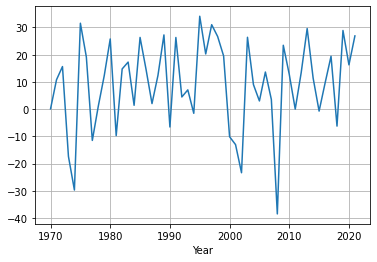

In [12]:
import pandas as pd

list_of_dfs = pd.read_html('https://en.wikipedia.org/wiki/S%26P_500')
first_df = list_of_dfs[1].iloc[:-4]  # last four columns are statistics
df = first_df.set_index('Year')

change_values_as_strings = df['Change in Index'].str.replace('−','-').str.replace('%','')  # cleaning up wierd characters
change_values_as_numbers = pd.to_numeric(change_values_as_strings)

change_values_as_numbers.plot(grid=True)

# HomeWork

For a more flexible application we could get the `woeid` from a city name or lat/lon coordinates by using other provided endpoints: `/api/location/search/?query=(query)` and `/api/location/search/?lattlong=(latt),(long)`

Create two functions:
```python
def get_woeid_from_city_name(city_name):
    ...

def get_woeid_from_latlon(lat, lon):
    ...
```

which will return the `woeid` for the given input. Then try to combine this with the previous code to produce a function that gets the weather for the next days.

In [16]:
def get_woeid_from_city_name(city_name):
    url = f"https://www.metaweather.com/api/location/search/?query={city_name}"
    response = requests.get(url)
    json_content = response.json()
    woeid = json_content[0]["woeid"]
    return woeid
    
    
def get_weather(city_id):
    return requests.get(f"https://www.metaweather.com/api/location/{city_id}").json()

### Possible solution

In [ ]:
def _get_woeid_from_city_name(city_name):
    json_data = requests.get(f"https://www.metaweather.com/api/location/search/?query={city_name}").json()
    if not json_data:
        raise ValueError(f"No city found with name: {city_name}")
    first_result_woeid = json_data[0]['woeid']
    return first_result_woeid
    
def _get_woeid_from_latlon(lat, lon):
    json_data = requests.get(f"https://www.metaweather.com/api/location/search/?lattlong={lat},{lon}").json()
    if not json_data:
        raise ValueError(f"No location found with latitude {lat} and longitude {lon}")
    first_result_woeid = json_data[0]['woeid']
    return first_result_woeid

# which can be tested with
_get_woeid_from_city_name("Glasgow")
_get_woeid_from_latlon(55.864200, -4.251800)

def _get_weather_from_woeid(woeid):
    json_data = requests.get(f"https://www.metaweather.com/api/location/{woeid}").json()
    json_data['consolidated_weather']
    return json_data
    
def print_weather(city_name=None, lat=None, lon=None):
    if city_name is None:
        woeid = _get_woeid_from_latlon(lat, lon)
    else:
        woeid = _get_woeid_from_city_name(city_name)
        
    weather_data = _get_weather_from_woeid(woeid)
    
    for i in weather_data['consolidated_weather']:
        print(i['applicable_date'], i['weather_state_name'])

# which can be tested with
print_weather("Glasgow")

### Creating a reusable package
Now that we have a few useful functions we might want to store them and reuse them.
Let's copy them into a python file `bespoke_samples/weather.py`

So we can import them as:
```python
from bespoke_samples import weather
weather.print_weather(..)
# or
from bespoke_samples.weather import print_weather
print_weather(..)
```

In [ ]:
from bespoke_samples import weather
weather.print_weather("Madrid")